## 05. Preliminary comparison of the $f_{\rm MM}$ between simulation and data

The notebook is similar to the notebook 02, which builds a major merger catalog. However, here things are done slightly differently: (1) halo pairs are generated, (2) the criteria are applied, rather than the other way around (as shown in notebook 02).

1. Loading data and defining input parameters
2. Finding pairs and creating a major/minor sample
2. Studying merger fraction $f_{MM}$ as a function of redshift

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 23rd April 2021

Import required packages

In [1]:
# scipy modules
from scipy.spatial import cKDTree

# astropy modules
import astropy.units as u
import astropy.io.fits as fits

from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# system imports
import os
import sys
import importlib as ib

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Load the imported file(s) that contains all the functions used in this notebooks

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [6]:
sys.path.append('imported_files/')
import Exploring_DM_Halos as edh
import Agn_incidence_from_Major_Mergers as aimm
import Comparison_simulation_with_literature_data as cswl
import plotting_cswl05 as pt

### 1. Defining input parameters

In [7]:
# look back into redshifts until...
redshift_limit = 2

# pixel number from the simulation file
pixel_no = '000000'

# define color palatte
pal = sns.hls_palette(10, h=.5, s=1).as_hex()

Define cosmology used in the notebook

In [8]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

Parameters for creating the Major Merger catalogue.

In [9]:
# get shell volume and projected radius bins [Mpc]
r_p, dr_p, shell_volume = aimm.shellVolume()

# time since merger [Gyr]
time_since_merger = 5

# time since merger array [Gyr]
dt_m_arr = [0.5, 1, 2, 3, 4]

# max mass ratio to classify as a major merger [dimensionless]
mass_max = 3

# defining the redshift bin for a merger in terms of dv = c*z [km/s]
dv_cut =  500

xoff_cut = 100

Booleans if one wants to skip running parts of the code

In [21]:
# if the pairs have already been computed before
run_find_pairs = False

# if we want to find all pairs (not just major pairs)
major_mergers_only = False
keyword = 'dv' # 'mm and dv' or 'all'

# if we want to find pairs passing the time since merger criteria
run_merger_pairs = False

### 2. Open files and get relevant data

In [11]:
_, hd_halo, _ = edh.getHeaders(pixel_no, np.array(['agn', 'halo']))

Extracting positions and redshifts of the AGNs, galaxies, and halos

In [12]:
# halos
_, _, conditions_halo = edh.getGalaxyData(hd_halo, '', redshift_limit)
hd_z_halo = hd_halo[conditions_halo]
print("Halos: %d"%(len(hd_z_halo) ))

Halos: 4506611


### 3.  Loading halo pairs (with and without selection cuts)

Get the `hd_file` for all the halo pairs. A quick test to understand how many pairs exists as a function of separation (without any regards to $M^*$, $\Delta t_{\rm MM}$, and $\Delta v$

In [ ]:
total_num_pairs = aimm.findPairs(hd_z_halo)

Note that here the definition of fraction of halo pairs is different to that used later in the notebook.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

# normalization
r_p, _, shell_volume = aimm.shellVolume()
N = len(hd_z_halo)*(len(hd_z_halo)-1)

# converting all units to kpc [vol: pc -> kpc; radius: Mpc -> kpc]

ax.plot( (1e3*r_p[1:]), total_num_pairs/(N*shell_volume*1e9), 'kx')

pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$f_{\rm halo\ pairs}}$ [Mpc$^{-3}$]', '', 'default', 'default', legend=False)
plt.savefig('figures/f_halo_pairs.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

The pairs are computed on the cluster with the ball tree algorithm. Refer to the python file for further details: `05_Preliminary_comparison_of_simulations_AGN_fraction_with_data.py` (same name as this notebook. The default values used were:
1. `mass_min = 0.33`, `mass_max = 3`
2. `dv_cut = 500`  

Can change these keywords in functions 1 and 2, respectively in the `.py` file.

The pairs computed in the last step is written to the directory `'Data/pos_z2/'`. Here, the pair indicies generated from the ball tree algorithm are loaded for further analysis.

In [18]:
pairs_all = cswl.openPairsFiles(key = 'all')
pairs_dv_all = cswl.openPairsFiles(key = 'dv', dv_cut=1000)
pairs_mm_all = cswl.openPairsFiles(key = 'mm and dv')

The time since major merger criteria was applied to the selected pairs (code can again be found in the `05_Pre...data.py` file). Corresponding function can be found in the `cswl` imported file. Here the chosen pair indicies are loads.

In [97]:
n_pairs_dt_all = cswl.concatAllTmmFiles(dt_m_arr, key = 'all')
n_pairs_dv_dt_all = cswl.concatAllTmmFiles(dt_m_arr, key = 'dv')
n_pairs_mm_dt_all = cswl.concatAllTmmFiles(dt_m_arr, key = 'mm and dv')

### 4. Generate control sample

In order to quantify an excess in the pairs as a function of seperation, we need to compute a relative 'control sample'. This control is constructed by executing the following steps:

* For a given pair, $p$, at a separation, $r$, all the halos pairs (generated without MM, $\Delta v$ selection; *no selection paired halos*) that have similar mass ratio $M_1/M_2$ are chosen.

* The mass-matched sample is then processed further to be redshift-matched i.e. it should be in the same mean redshift range $\pm 0.1$ as $p$. 

* Now, 1 data point on the plot is the sum of all the paired halos at that separation, r. So similarly, I sum all the *no selection paired halos* that pass the redshift & mass criteria to generate a comparable value of number density for the 'control' sample at any given separation.


The code that executes this can be found in `Generate_control_sample.py`, with it's corresponding function in `cswl`.

In [108]:
num_control_pairs = []
for r in [0, 1, 2]:
    m_matched_control = np.load('Data/pairs_z%.1f/control_pairs_idx_r%.1f.npy'%(redshift_limit, r), allow_pickle=True)
    
    # get the total number of 'no selection pairs' for the chosen separation
    num_control_pairs.append(m_matched_control[1])

In [96]:
num_control_pairs

[232829, 13515328, 102388593]

In [110]:
len(pairs_all[0][1])

4506611

### 4. Studying the effect of $\Delta t_{\rm merger}$ on MM pairs

Now that all the pairs for the chosen cases of time since major mergers are computed, we can proceed to calculate the number density of halo pairs for each case.

$$n_{\rm{ halo\ pairs}}\ \rm{[kpc^{-3}]} \ = \frac{\rm{ NP}}{\rm{ N(N-1)} \times {\rm Shell\ volume}}$$

where $NP$ is the number of pairs and $N$ is the total number of objects from which pairs are chosen.

In [107]:
num_control_pairs

<Quantity [2.30508718e-14, 1.94494546e-13, 4.00760021e-13] 1 / pc6>

In [106]:
N = 2*len(hd_z_halo)*(len(hd_z_halo) - 1)
num_control_pairs = num_control_pairs/(N*shell_volume[:len(num_control_pairs)])
num_control_pairs*1e9

<Quantity [2.30508718e-05, 1.94494546e-04, 4.00760021e-04] 1 / pc6>

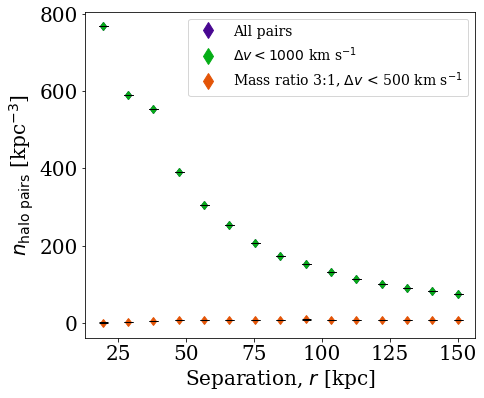

In [11]:
ax, n_pairs, n_pairs_err = pt.plotNpSep(ax, hd_z_halo, pairs_all, '#480791', 'All pairs') 
ax, n_dv_pairs, n_pairs_dv_err = pt.plotNpSep(ax, hd_z_halo, pairs_dv_all, '#05ad16', r'$\Delta v < 1000 $ km s$^{-1}$')
ax, n_mm_pairs, n_pairs_mm_err = pt.plotNpSep(ax, hd_z_halo, pairs_mm_all, '#e35407', r'Mass ratio 3:1, $\Delta v$ < 500 km s$^{-1}$')

#ax.set_yscale("log")
pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$n_{\rm halo\ pairs}}$ [kpc$^{-3}$]', '', 'default', 'default', legend=True)
plt.savefig('figures/f_halo_pairs.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

$$f_{\rm halo\ pairs} = \frac{n_{\rm pairs}(\rm Mass\ ratio\ < 3:1; \Delta \ v < 500 km\ s^{-1})}{n_{\rm total\ pairs}}$$

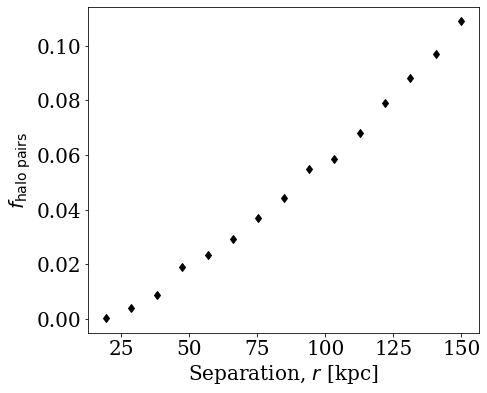

In [33]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

ax.plot( r_p_kpc , n_mm_pairs/n_pairs, 'kd')

pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$f_{\rm halo\ pairs}}$', '', 'default', 'default', legend=False)

Plot shows that the major merger (mass ratio) criteria encompasses the $\Delta v$ criterion in redshift. So by imposing mass ratio, we are automatically selecting only those pairs that are close to each other in redshfit i.e. $\Delta v = c \Delta z$.

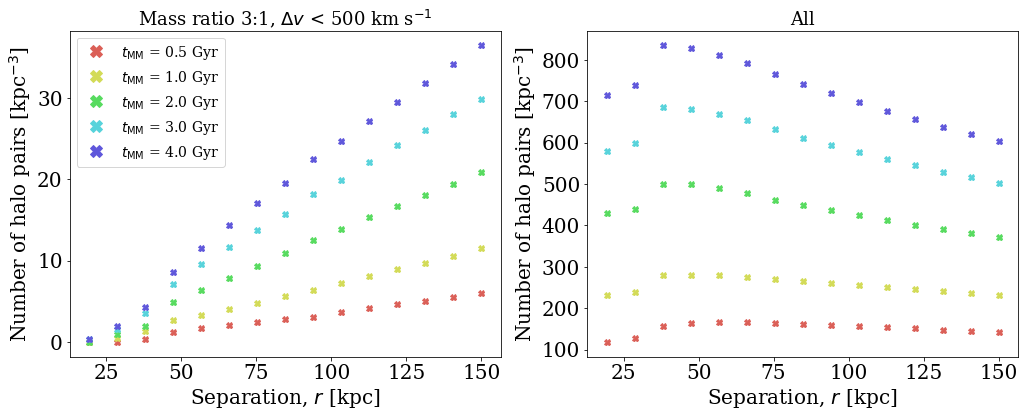

In [36]:
fig, ax = plt.subplots(1,2,figsize=(17,6))
pal = sns.color_palette("hls", len(dt_m_arr)+1).as_hex()
errorbars = [False, False, False, False, False]
N = 2*len(hd_z_halo)*(len(hd_z_halo)-1)

for t_idx in range(len(dt_m_arr)):
    np_dt, np_mm_dt = n_pairs_dt_all[t_idx], n_pairs_mm_dt_all[t_idx]    
    ax[0].plot( (1e3*r_p[1:]), (np_mm_dt[1:]*1e9)/(N*shell_volume), 'kX', label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx])
    ax[1].plot( (1e3*r_p[1:]), (np_dt[1:]*1e9)/(N*shell_volume), 'kX', color=pal[t_idx])

pt.setLabel(ax[0], r'Separation, $r$ [kpc]', r'Number of halo pairs [kpc$^{-3}$]', r'Mass ratio 3:1, $\Delta v$ < 500 km s$^{-1}$', 'default', 'default', legend=True)
pt.setLabel(ax[1], r'Separation, $r$ [kpc]', r'Number of halo pairs [kpc$^{-3}$]', 'All', 'default', 'default', legend=False)

Now there is an additional condition in pair selection: $T_{mm}=t$, where $t$ goes from $0.5$ Gyr to $4$ Gyr.

$$f_{\rm halo\ pairs} = \frac{n_{\rm pairs}(\rm Mass\ ratio\ < 3:1; \Delta \ v < 500 km\ s^{-1};\ T_{mm}=t)}{n_{\rm total\ pairs}}$$

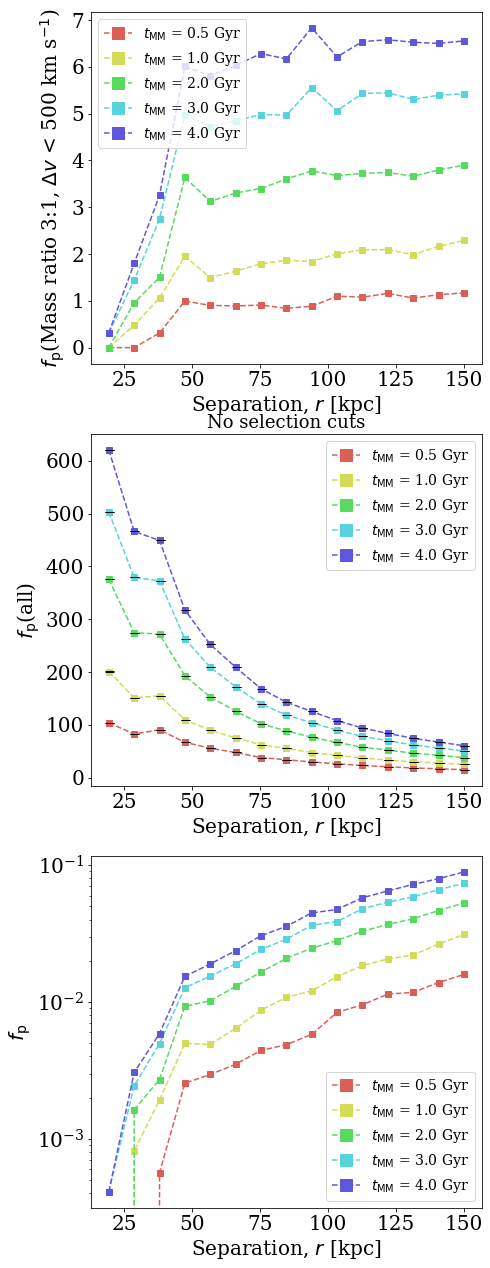

In [27]:
ib.reload(pt)
fig, ax = plt.subplots(3,1,figsize=(7,22))

for t_idx in range(len(dt_m_arr)):
    np_dt, np_mm_dt = n_pairs_dt_all[t_idx], n_pairs_mm_dt_all[t_idx]    
    n_p, n_p_err = cswl.nPairsToFracPairs(hd_z_halo, np_dt)
    n_p_mm, n_p_mm_err = cswl.nPairsToFracPairs(hd_z_halo, np_mm_dt)
    
    # plot 1 and 2
    _ = pt.plotFpairs(ax[0], r_p, n_p_mm, n_p_mm_err, label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx], errorbar = False)
    _ = pt.plotFpairs(ax[1], r_p, n_p, n_p_err, label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx], errorbar = True)
    
    # we divide by n_pairs (has no cuts on pairs) to get the fraction of halo pairs
    norm = 2*len(hd_z_halo)*(len(hd_z_halo)-1)*shell_volume
    _ = pt.plotFpairs(ax[2], r_p, n_p_mm/n_pairs, f_p_err, label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx], errorbar = False)
    
pt.setLabel(ax[0], r'Separation, $r$ [kpc]', r'$f_{\rm p}}$(Mass ratio 3:1, $\Delta v$ < 500 km s$^{-1}$) ', '', 'default', 'default', legend=True)
pt.setLabel(ax[1], r'Separation, $r$ [kpc]', r'$f_{\rm p}}$(all) ', 'No selection cuts', 'default', 'default', legend=True)
pt.setLabel(ax[2], r'Separation, $r$ [kpc]', r'$f_{\rm p}}$', '', 'default', 'default', legend=True)

ax[2].set_yscale('log')
plt.savefig('figures/f_halo_pairs_dt.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

Let's look at the distribution of the scale factor of the chosen pairs.

In [55]:
halo_m_scale_arr_all_r = cswl.getAllMMscales(hd_halo[conditions_halo], pairs_mm_all, r_p)

TO BE UPDATED: The selection applied is to choose pairs > $t_{\rm MM}$ lines. 

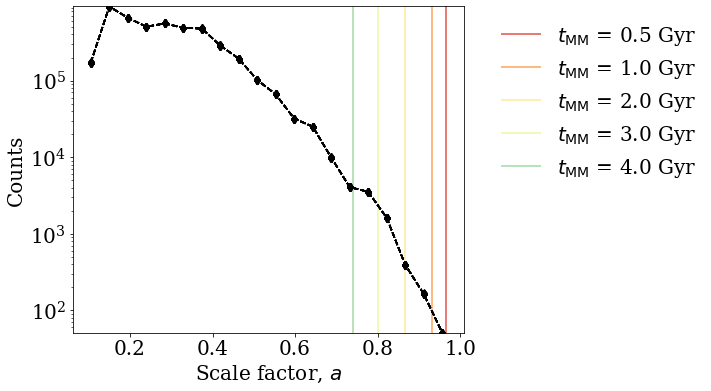

In [71]:
pt.plotScaleMMdistribution(halo_m_scale_arr_all_r, cosmo, dt_m_arr)

### 5. Quantifying morphology with X$_{\rm off}$

TODO: Divide my $R_{\rm vir}$

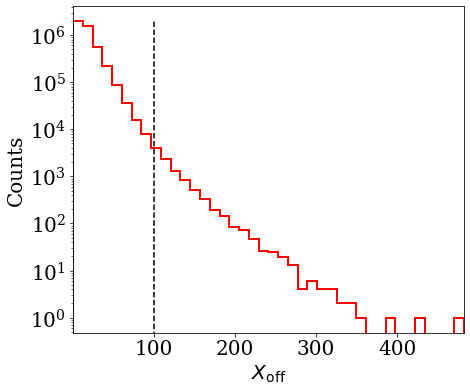

In [35]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

hd_halo_z = hd_halo[conditions_halo]

counts_xoff, _, _ = ax.hist(hd_halo_z['HALO_Xoff'], bins=40, histtype='step', color='r', lw=2)
ax.vlines(xoff_cut, np.min(counts_xoff), np.max(counts_xoff), linestyles='--', colors='k')

xoff_min, xoff_max = np.min(hd_halo_z['HALO_Xoff']), np.max(hd_halo_z['HALO_Xoff'])
pt.setLabel(ax, r'$X_{\rm off}$', r'Counts', '', [xoff_min, xoff_max], 'default', legend=False)
ax.set_yscale('log')